# Tensorflow(Keras) & ONNX

In this tutorial, we investigate a conversion of the [Tensorflow (Keras)](https://www.tensorflow.org/) model to the [ONNX](https://onnx.ai/) format and compare both models. For performing this experiment, we selected the "adult" classification data set. It contains a combination of numeric and categorical features.

## Setup Environment

But before we start, let's set up our working environment. It will help us to keep the project directory clean. All artifacts generated within the project will be placed to the "tmp" dir and will be ignored by Git.

In [1]:
# Let's make a temporary directory for all artifacts created by this notebook.
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')

## Prepare Dataset

For creating the ML model we are loading the "adult" dataset and selecting the following features:

| Feature      | Kind        | Type    | Enforce(*) |
| -------------| ----------- | ------- | ---------- |
| Age          | numeric     | int64   | no         |
| fnlwgt       | numeric     | int64   | no         |
| EducationNum | numeric     | int64   | no         |
| CapitalGain  | numeric     | int64   | no         |
| CapitalLoss  | numeric     | int64   | no         |
| HoursPerWeek | numeric     | int64   | no         |
| WorkClass    | categorical | object  | no         |
| Education    | categorical | object  | no         |
| MaritalStatus| categorical | object  | no         |
| Occupation   | categorical | object  | no         |
| Relationship | categorical | object  | no         |
| Race         | categorical | object  | no         |
| Gender       | categorical | object  | no         |
| NativeCountry| categorical | object  | no         |

(*) We will enforce types for features whose original types have been detected differently from our expectations.

For this dataset, all types are detected correctly and not enforcement is needed.

In [2]:
import numpy as np
from utils import load_dataset

# Sets the loading dataset name.
dataset_name = 'adult'

# Loads the dataset.
dataset = load_dataset(dataset_name)

Unfortunately in this experiment, we can not use the processing pipeline as in SKLearn and XGBoost notebooks. We need manually transform input and output features, and adjust their type. Part of this process we can do with the feel of our data preprocessing function. Fo the rest we will use Numpy functions.

In [3]:
from utils import create_preprocessor
from sklearn.model_selection import train_test_split

# Creates a data preprocessing pipeline.
preprocessor = create_preprocessor(dataset)

# The following code: 
#    1) Normalizes the numeric and encodes the categorical features; 
#    2) Converts the sparse matrix into the normal 2d array;
#    3) Transforms all array values to "float32";
X = preprocessor.fit_transform(dataset.X).toarray().astype(np.float32)

# Here we need to transform the "string" definition to "int32" for the
# target feature.
y = np.array([[0,1] if v == '>50K' else [1,0] for v in dataset.y])

# Makes data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

print('Loaded "%s" datase:' % dataset_name)
print('   - number of training samples: %s' % str(X_train.shape))
print('   - number of test samples:     %s' % str(X_test.shape))

Loaded "adult" datase:
   - number of training samples: (21815, 108)
   - number of test samples:     (10746, 108)


## Train & Test Tensorflow(Keras) Model

Let's define the topology of the classification model using Keras layers.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Builds models in Keras using the Sequential interface.
model = Sequential()

# Adds a first Dense supplying the input shape of your data.
model.add(Dense(100, input_shape=[X_train.shape[1]], activation='relu'))

# Adding more Dense layers to learn more complex relationships. 
# We will Dropout layers to prevent model overfitting.
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# Lets use Last Dense layer with the Sigmoid activation (due to the  binary 
# classification)
model.add(Dense(2, activation='softmax'))

#  Compiles the model and prints its summary.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2021-09-16 16:02:03.230857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-09-16 16:02:03.230880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

2021-09-16 16:02:05.551455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 16:02:05.552162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-09-16 16:02:05.552341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-09-16 16:02:05.552495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file

Now when the model is defined, let's train it.

 **Please note**, our goal for this tutorial is not to create the best classification model for the "adult" dataset. So we will not focus on picking the best feature and optimizing hyperparameters. Our goal is to learn more about ONNX! :wink:

In [5]:
from tensorflow import keras
from sklearn.metrics import accuracy_score


save_best_model_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('tmp', 'best_weights.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Trains the Tenserflow (Keras) model.
model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, 
          validation_data=(X_test,y_test), callbacks=[save_best_model_callback])

# Loads the best model weights.
model = keras.models.load_model(os.path.join('tmp', 'best_weights.h5'))

# Uses the model for scoring.
y_tensorflow_probas = model.predict(X_test)                 # collects the prediction probabilities;
y_tensorflow_pred = np.argmax(y_tensorflow_probas, axis=1)  # collects the predicted labels;

# Just for convenience name the test.y labels as the ground truth.
y_true = np.argmax(y_test, axis=1)

# Computes the accuracy score.
tensorflow_accuracy = accuracy_score(y_true, y_tensorflow_pred)
print('The model accuracy: %.2f' % tensorflow_accuracy)

# Re-saves the model using TF format.
model.save(
    os.path.join('tmp', 'model.h5'),
    overwrite=True, include_optimizer=False, save_format='tf'
)

2021-09-16 16:02:05.778036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
341/341 [==============================] - 1s 2ms/step - loss: 0.3572 - accuracy: 0.8306 - val_loss: 0.3109 - val_accuracy: 0.8565
Epoch 2/10
341/341 [==============================] - 0s 1ms/step - loss: 0.3191 - accuracy: 0.8538 - val_loss: 0.3109 - val_accuracy: 0.8597
Epoch 3/10
341/341 [==============================] - 0s 1ms/step - loss: 0.3129 - accuracy: 0.8550 - val_loss: 0.3076 - val_accuracy: 0.8590
Epoch 4/10
341/341 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8554 - val_loss: 0.3088 - val_accuracy: 0.8586
Epoch 5/10
341/341 [==============================] - 0s 1ms/step - loss: 0.3046 - accuracy: 0.8588 - val_loss: 0.3098 - val_accuracy: 0.8576
Epoch 6/10
341/341 [==============================] - 0s 1ms/step - loss: 0.3023 - accuracy: 0.8612 - val_loss: 0.3117 - val_accuracy: 0.8589
Epoch 7/10
341/341 [==============================] - 0s 1ms/step - loss: 0.2983 - accuracy: 0.8614 - val_loss: 0.3099 - val_accuracy: 0.8565
Epoch 

The trained ML model was completed and showed an accuracy of **86%**. Our last step in the previous code-block was to save the model graph and weights in the "model.h5" file using Tensorflow format.

## Convert Test Tensorflow(Keras) Model To ONNX

Next, we need to convert the Tensorflow(Kears) model into the ONNX format and serialize it to the file. The conversion process is done by the [tf2onnx](https://github.com/onnx/tensorflow-onnx) package. Our initial attempt was to use [keras-onnx](https://github.com/onnx/keras-onnx), but we encountered an error, to resolve, which the **tf2onnx** was recommended. This is why we saved the model using the Tensorflow format in the previous step.

In [6]:
import tf2onnx.convert

# Loads the model saved TF format.
model = keras.models.load_model(os.path.join('tmp', 'model.h5'))
onnx_model, _ = tf2onnx.convert.from_keras(model)

# # Converts the model to the ONNX format.
onnx_filename = 'model.onnx'

# Serializes the ONNX model to the file.
with open(os.path.join('tmp', onnx_filename), "wb") as f:
    f.write(onnx_model.SerializeToString())
    print('The ONNX model has been successfully saved in "model.onnx" file.')

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
The ONNX model has been successfully saved in "model.onnx" file.


2021-09-16 16:02:11.438243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 16:02:11.438515: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-09-16 16:02:11.438616: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-16 16:02:11.438940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 16:02:11.439181: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and 

## Load & Test ONNX Model

To load the model, we just need to specify its file name in the runtime.

```Python
sess = rt.InferenceSession(os.path.join('tmp', onnx_filename))
```

The ONNX model uses this dictionary for inference. The **X_test** data are already correctly formatted. Pay attention to the dictionary key.

```Python
sess.get_inputs()[0].name
```

This line will return the name of the first layer in our model. Do not name it manually! Since during the notebook re-run the name of the first layer might changes!

In [7]:
import onnxruntime as rt

sess = rt.InferenceSession(os.path.join('tmp', onnx_filename))

y_onnx_probas = sess.run(None, {sess.get_inputs()[0].name: X_test})
y_onnx_pred = np.argmax(y_onnx_probas[0], axis=1)

onnx_accuracy = accuracy_score(y_true, y_onnx_pred)
print('The ONNX model accuracy: %.2f' % onnx_accuracy)

The ONNX model accuracy: 0.86


The ONNX model showed an accuracy of **86%**, the same accuracy as the original Tensorflow(Keras) model.

## Compare Tensorflow(Keras) & ONNX Models 

Even we do not expect a difference between Tensorflow(Keras) and ONNX model accuracies, let's visualize the confusion matrix. In this confusion matrix, we will consider predictions generated by the Tensorflow(Keras) model as a ground truth (GT).

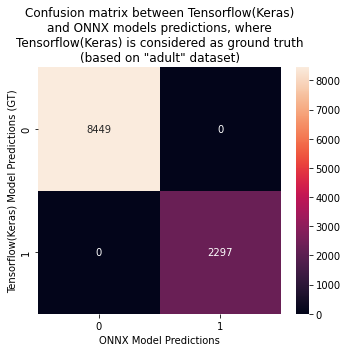

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Creates the confusion matrix.
cm = confusion_matrix(y_tensorflow_pred, y_onnx_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))

# Makes a confusion matrix plot.
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title( f'Confusion matrix between Tensorflow(Keras)\nand ONNX models predictions, where\nTensorflow(Keras) is considered as ground truth\n(based on "{dataset_name}" dataset)' )
ax.set_xlabel("ONNX Model Predictions")
ax.set_ylabel("Tensorflow(Keras) Model Predictions (GT)")
plt.tight_layout()

Despite the same accuracy, we expect some differences in prediction probabilities. To visualize these differences, we substruct ONNX probabilities from Tensorflow(Keras) probabilities and then plot the distribution of differences using a box plot.

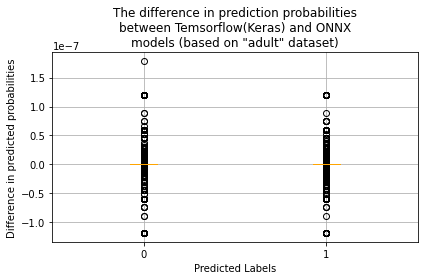

In [9]:
# Convert Tensorflow(Keras) and ONNX probabilities into Pandas data frame.
# This will help us to perform mathematical operations later.
df_tensorflow_probas = pd.DataFrame(y_tensorflow_probas, columns=[0, 1])
df_onnx_probas = pd.DataFrame(y_onnx_probas[0], columns=[0, 1])

# Computes a difference between Tensorflow(Keras) and ONNX probabilities.
df_diff = df_tensorflow_probas - df_onnx_probas

# Makes a Box plot.
poxplot = df_diff.boxplot(color={'medians': 'orange'})
plt.title( f'The difference in prediction probabilities\nbetween Temsorflow(Keras) and ONNX\nmodels (based on "{dataset_name}" dataset)' )
plt.xlabel("Predicted Labels")
plt.ylabel("Difference in predicted probabilities")
plt.tight_layout()
plt.savefig(os.path.join('tmp', f'diff_tensorflow.jpg'))